In [1]:
using Revise

In [2]:
using Pkg
Pkg.activate(homedir()*"/GIT/susie-glmm/SuSiEGLMM.jl")

  Activating project at `~/GIT/susie-glmm/SuSiEGLMM.jl`


In [3]:
using Statistics, Distributions, StatsBase, Random, LinearAlgebra, Distributed,GLM,DelimitedFiles

In [4]:
using SuSiEGLMM

┌ Info: Precompiling SuSiEGLMM [9b1f91f2-0b73-4b7e-a057-f3f9c7f13fe1]
└ @ Base loading.jl:1423


In [5]:
?glmmSusie

search: glmmSusie



```
 glmmSusie(y::Vector{Float64},X::Matrix{Float64},X₀::Union{Matrix{Float64},Vector{Float64}},T::Matrix{Float64},
      S::Vector{Float64};tol=1e-4,τ²::Float64 = 1.99,L::Int64=10,Π::Vector{Float64}=ones(size(X,2))/size(X,2),σ0::Vector{Float64} = ones(L))


 Fit a logistic mixed model for SUSIE (sum of single effects).  Returns a type of `Result`, struct of arrays.
```


In [6]:
#genotype matrix and impute missing values
@time geno=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/ascertained_pop_genotype_12_10.txt";header=true);

X = geno[1][:,6:end]

for j =axes(X,2)
    idx = findall(X[:,j].=="NA")
    X[idx,j].= missing
    X[idx,j] .= mean(skipmissing(X[:,j]))
end

#empirical grm
K0=readdlm(homedir()*"/GIT/SuSiEGLMM.jl/testdata/causal1/pop/pop_grm.txt");
K0=Symmetric(K0);K0=convert(Matrix{Float64}, K0);

  1.497411 seconds (18.28 M allocations: 524.577 MiB, 17.87% gc time, 27.31% compilation time)


In [7]:
Seed(24)

In [8]:
T,S = svdK(K0;LOCO=false) 

([-0.03009495162366858 -0.031199170200303952 … 0.02250555702743749 -0.032300622574000716; 0.018922699570053384 -0.011274405950787193 … -0.08587528642298964 -0.06720273463442801; … ; 0.030711943755013932 -0.08417309847479863 … 0.001685475850207202 -0.02001944231048721; -0.044587796206770926 -0.0445877962067711 … -0.04458779620677096 -0.04458779620677122], [1.8498635657424751, 1.8261737315279054, 1.8023586994816634, 1.795369895112748, 1.7886748954597398, 1.77722900960392, 1.76599079160014, 1.7489955943284636, 1.7484990825208595, 1.73815229501913  …  0.4543734391818463, 0.45258719285154625, 0.4482105576406595, 0.4445639720846187, 0.44317598472484143, 0.438904667753285, 0.43267495350217544, 0.4293582332306149, 0.4197027678053472, 1.7510186732697898e-15])

In [9]:
size(X)

(503, 4000)

In [10]:
X1= (X.-mean(X,dims=1))./std(X,dims=1)
n,p = size(X1)

L=1; B=1;
tol=1e-4
b_true=zeros(p);
b_1s=zeros(B); 


In [11]:
# data preparation
    τ2= 1.5  # true τ²

#for j = 1:B
    b_true[1]= randn(1)[1] 

    g=rand(MvNormal(τ2*K0)) #grm
    p= logistic.(X1*b_true+g) 
    #generating binary outcome
    Y=convert(Vector{Float64} ,rand.(Bernoulli.(p))) ;  
    X₀=ones(n,1); #covariates(intercepts)

In [12]:
b_true[1] # true b

0.12169754246032718

In [287]:
 # transforming data         
     Xt, Xt₀, y1 = SuSiEGLMM.rotate(Y,X1,X₀,T)   
#      y1= SuSiEGLMM.rotateY(Y1,T)

#initial values
#     τ² =2.0.^[-10:0.5:2.5;] # the range of τ²
  

([0.6203341866904861 1.2821380992099884 … 1.043867526136292 -0.1389906140735533; -0.6509038299601514 -1.2818875721823844 … -1.4765123447412196 0.9787359714523717; … ; 0.3973684522059859 -0.6252119514266032 … 0.2937676417753836 -0.4056734188047211; 2.498001805406602e-16 -1.3877787807814457e-15 … -1.3877787807814457e-15 -3.7192471324942744e-15], [8.104628079763643e-15; -1.7763568394002505e-15; … ; 5.176414852314792e-15; -22.427661492005853;;], [0.7380182007198995, 0.4932809620366664, -0.20932647335519852, 0.23574420649902875, -0.3390369393086783, -0.3800707480870755, 0.4493067890313288, -0.07527503784950619, 1.0065495959264241, 0.34437937462374313  …  -0.5050540161006902, 0.04812784483224336, 0.6473613710563536, -0.19269570999865615, -0.06470431183997619, 0.7611326098578076, -0.03169940760200806, -0.14082160584554093, -0.07353240261188163, 0.6911108412049504])

In [13]:
#debugging
@time res= glmmSusie(Y,X1,X₀,T,S;tol=tol,τ²= 2.5,L=L)


603
 27.252065 seconds (15.07 M allocations: 34.603 GiB, 11.85% gc time, 16.14% compilation time)


Result([0.6524901182755911, 0.6184070968466127, 0.5943665763273984, 0.59448456203368, 0.5994032482415731, 0.6004846477838822, 0.6042359291378836, 0.5823473445565246, 0.6744000444794052, 0.5916156772494535  …  0.30955338895943496, 0.3053677182659665, 0.309713935703812, 0.3031921977927418, 0.3022731558892352, 0.3085713469350707, 0.29870644878756264, 0.2978323051344029, 0.2943472226636677, 387.11614412912763], [-17.22842782143601], [0.00011555910625579783], 0.21061676102332783, -659.5636349583392, [0.00026010953356224697; 0.00025035081029284485; … ; 0.00024955448027751093; 0.0002528484160712172;;], [0.0032477313605729103; -0.001350480971123967; … ; -0.0010475188478008975; 0.0020219294738140635;;], [0.00011404312077513636; 0.00011404517578826095; … ; 0.00011404499816229501; 0.00011404502041071244;;])

In [21]:
[res.ν[1:5] res.α[1:5]]

5×2 Matrix{Float64}:
  0.00324773   0.00026011
 -0.00135048   0.000250351
  0.00137522   0.000250424
 -0.000558142  0.000248696
  0.000187907  0.000248395

In [300]:
X₀

503×1 Matrix{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [242]:
τ²=1.99; Π=ones(p)/p;σ0=ones(L);
Σ0= 2(cov(Xt₀)+I) # initial variance of prior β
ξ0=guessξ0(y1,Xt₀,Xt,S,Σ0,τ²,σ0,Π,n,L)

Xy₀=SuSiEGLMM.getXy('T',Xt₀,y1)
Badj= intβOut(Xy₀,y1,Xt₀,Σ0,ξ0,n) 

intOut([0.4307742070354993;;], [-35.981727194550245], [0.7380182007199507, 0.4932809620366551, -0.20932647335519286, 0.23574420649905492, -0.3390369393086967, -0.38007074808708086, 0.44930678903129045, -0.07527503784950708, 1.0065495959263921, 0.34437937462373386  …  -0.5050540161006711, 0.04812784483220738, 0.6473613710564481, -0.19269570999859847, -0.06470431183994825, 0.7611326098578247, -0.031699407602064515, -0.14082160584559789, -0.0735324026118394, 0.401086479829557], [0.17561276958721417, 0.17624690280351132, 0.17686404107337775, 0.17705289578756672, 0.1772204811097033, 0.1775268778410138, 0.17783076804123119, 0.1782866724091776, 0.1783054751785328, 0.1785844113702009  …  0.22506367991207377, 0.2251500584550706, 0.225363119768363, 0.22553800695881884, 0.22561818879569284, 0.22581374737654525, 0.22611998026381633, 0.2262800597987398, 0.22675300657374733, 0.0003593920617007933], [1.4232761835615985e-15 -3.1307739121812847e-16 … 1.1737676310353795e-15 -0.008060323502739473], [2.67

In [289]:
Badj.β̂

1-element Vector{Float64}:
 -23.640100541443648

In [277]:
#  ghat =zeros(n); Vg = zeros(n);
#     ghat2=zeros(n); τ2_new=zeros(1); τ2 =[τ²]; 
    
#     βhat=zeros(c)
#     A0 =repeat(Π,outer=(1,L)) ; 
#     B0=zeros(p,L); AB2=zeros(p,L)
   
#     A1 =copy(A0); B1=zeros(p,L); Sig1=zeros(p,L)
#     σ0_new = zeros(L); ξ_new = zeros(n);

#  el0=0.0;
# Badj= intβOut(Xy₀,y1,Xt₀,Σ0,ξ0,n) 
# postG!(ghat,Vg,Badj,Xt,S,τ2,A0,B0)
# emG!(ghat2,τ2_new,Vg,ghat,S)

postB!(A1, B1, Sig1,Badj,ghat,Xt,σ0,A0,B0,Π,L)
σ0_new, AB2 = emB(A1, B1, Sig1,L)
mStep!(ξ_new,A1,B1,Sig1,ghat,Vg,Badj,Xt,Xt₀,n)
el1=ELBO(ξ_new,σ0_new,τ2_new,Badj,A1,B1,AB2,Sig1,Π,ghat,ghat2,Vg,S,Xt,Xy₀,Σ0,L,n)

# crit=abs(el1-el0)
# ξ0[:]=ξ_new; τ2[:]=τ2_new;el0=el1;σ0[:]=σ0_new;βhat[:]=Badj.β̂;
#          A0[:,:]=A1;B0[:,:]=B1
        

-688.3037305907769

In [278]:
[σ0 σ0_new]

1×2 Matrix{Float64}:
 0.0116125  0.00773446

In [279]:
[ξ0 ξ_new]

503×2 Matrix{Float64}:
   2.18471     2.13398
   1.77679     1.73949
   1.48504     1.4605
   1.50019     1.47505
   1.58349     1.55437
   1.62096     1.59003
   1.69475     1.66074
   1.41481     1.39306
   2.64347     2.58615
   1.57112     1.54229
   1.86755     1.82661
   3.28979     3.23635
   1.48032     1.45544
   ⋮         
   0.874822    0.85898
   1.03308     1.00929
   0.932049    0.91323
   0.854354    0.839341
   0.972162    0.951067
   0.858492    0.843031
   0.847381    0.832447
   1.00356     0.980685
   0.837853    0.823091
   0.840699    0.825659
   0.828403    0.8137
 619.969     530.915

In [275]:
# gs=zeros(n,4)
gs[:,:]=[ghat ghat2 S Vg]
gs

503×4 Matrix{Float64}:
  1.55317       4.52246      1.84986      2.11013
  0.993047      3.00602      1.82617      2.01988
 -0.408181      2.12222      1.80236      1.95561
  0.4586        2.16388      1.79537      1.95357
 -0.663658      2.40312      1.78867      1.96268
 -0.743439      2.51402      1.77723      1.96131
  0.881018      2.74219      1.76599      1.96599
 -0.143756      1.93135      1.749        1.91068
  2.12691       6.64125      1.7485       2.11752
  0.662307      2.36622      1.73815      1.92757
 -1.16037       3.31738      1.73116      1.97091
 -2.86231      10.3999       1.72723      2.2071
 -0.454689      2.10769      1.71896      1.90095
  ⋮                                       
 -0.156691      0.735142     0.459797     0.71059
 -0.551709      1.01347      0.456579     0.709088
 -0.355644      0.83099      0.454373     0.704508
  0.0336485     0.702103     0.452587     0.700971
  0.450798      0.900373     0.448211     0.697155
 -0.133036      0.708328     0.

In [258]:
[ghat ghat2 S Vg]

503×4 Matrix{Float64}:
  1.59677       4.72592     1.84986      2.17624
  1.02103       3.12787     1.82617      2.08537
 -0.418988      2.19075     1.80236      2.0152
  0.469304      2.23398     1.79537      2.01374
 -0.682421      2.48971     1.78867      2.02401
 -0.764698      2.60784     1.77723      2.02308
  0.906089      2.84969     1.76599      2.02869
 -0.148333      1.98951     1.749        1.9675
  2.17879       6.91998     1.7485       2.17283
  0.681169      2.45153     1.73815      1.98754
 -1.19469       3.46088     1.73116      2.03359
 -2.91015      10.7162      1.72723      2.24721
 -0.467309      2.17716     1.71896      1.95878
  ⋮                                      
 -0.161591      0.761613    0.459797     0.735501
 -0.570481      1.05968     0.456579     0.734231
 -0.368159      0.864858    0.454373     0.729317
  0.034719      0.726774    0.452587     0.725568
  0.46611       0.93911     0.448211     0.721851
 -0.137922      0.733956    0.444564     0.714934


In [232]:
 #posterior
#         Vg[:]= 1.0./(Badj.λ+1.0./(τ2[1]*S))
        
#         ghat[:]= SuSiEGLMM.getXy('N',Xt,sum(A0.*B0,dims=2)[:,1])
#         ghat[:]= Badj.Ŷ -lmul!(Diagonal(Badj.λ),ghat)
#         lmul!(Diagonal(Vg),ghat)
#          ghat2[:]= Vg+ghat.^2 
    #m-step for τ²
    τ2_new[:].= mean(ghat2./S)

1-element view(::Vector{Float64}, :) with eltype Float64:
 1.787907725248363

In [276]:
[τ2 τ2_new]

1×2 Matrix{Float64}:
 1.85555  1.78609

## Testing score test 

In [77]:
#fix true values of parameters
τ2=1.25;b_true[1]=randn(1)[1]
println(b_true[1])#true b
# init0=[]; init1=[]
B=200

#  tt=zeros(B);
#Ps=zeros(p,R); 
#  Ts1=zeros(p,B);#Ps1=zeros(p,R);
Y0=zeros(n,B);
Y1=zeros(n,B);


for j = 1:B
#     b_true[1]= randn(1)[1] # true b 
#     b_1s[j] = b_true[1]   
   
# data generation
    g=rand(MvNormal(τ2*K0)) #grm
    
    p0= logistic.(g)
    p1=logistic.(X1*b_true+g) 
    
    Y0[:,j]=rand.(Bernoulli.(p0)) #H0 data
    Y1[:,j]=rand.(Bernoulli.(p1)) #H1 data
    # similarily :
#     Y[:,j] = collect(Iterators.flatten(rand.(Bernoulli.(p1), 1))) 
    # Y0[:,j]=Y1
end

-0.4835980243053348


In [78]:
size(Y0)

(503, 200)

In [79]:
#score test
Ts0=[];Pv0=[];S0=[];V0=[]; init0=[];init1=[]
Ts1=zeros(B);P1=zeros(B);S1=zeros(B);V1=zeros(B);
τ0=2.0

for j =1:B
       est0,Xt₀ = glmmNull(Y0[:,j],X₀,T,S;tol=tol,τ0=τ0)
       T0, P0, s0, v0 = testStats(est0,Y0[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)
        Ts0=[Ts0;T0];Pv0=[Pv0;P0];S0=[S0;s0];V0=[V0;v0]
       
       est1,Xt₀ = glmmNull(Y0[:,j],X₀,T,S;tol=tol,τ0=τ0)
       Ts1[[j]], P1[[j]], S1[[j]], V1[[j]] = testStats(est1,Y1[:,j],X1[:,[1]],Xt[:,[1]],X₀,Xt₀,T,S)
       init0=[init0;est0]; init1=[init1;est1]
end
       

    

819
819
965
965
978
978
487
487
727
727
565
565
612
612
450
450
427
427
526
526
496
496
387
387
867
867
588
588
413
413
1077
1077
747
747
685
685
676
676
610
610
428
428
415
415
653
653
376
376
448
448
681
681
647
647
401
401
310
310
630
630
468
468
435
435
299
299
621
621
500
500
846
846
740
740
1137
1137
335
335
919
919
518
518
721
721
578
578
1075
1075
1071
1071
590
590
493
493
359
359
366
366
477
477
433
433
684
684
448
448
808
808
651
651
478
478
512
512
482
482
698
698
533
533
465
465
656
656
671
671
806
806
787
787
818
818
849
849
726
726
761
761
533
533
605
605
914
914
942
942
571
571
391
391
666
666
624
624
455
455
734
734
527
527
580
580
537
537
564
564
522
522
644
644
556
556
776
776
579
579
473
473
550
550
488
488
458
458
699
699
685
685
618
618
646
646
659
659
342
342
569
569
578
578
632
632
412
412
615
615
1006
1006
621
621
756
756
355
355
1306
1306
439
439
578
578
744
744
398
398
972
972
957
957
678
678
625
625
614
614
874
874
621
621
777
777
938
938
673
673
836
836
665


In [85]:
α=mean(Pv0.<0.05) # type 1 error estimate

0.26

In [87]:
mean(P1.<α) # power

0.9

In [89]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


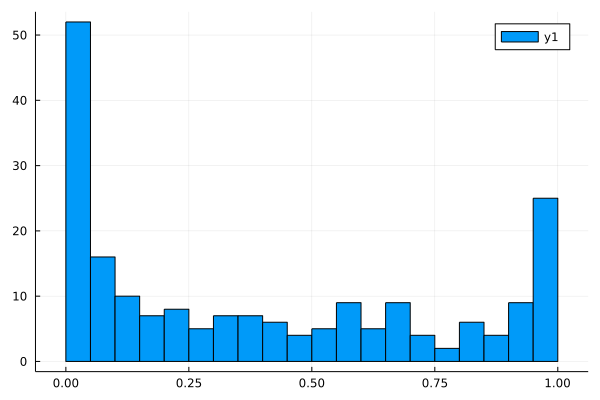

In [92]:
histogram(Pv0,bins=0:0.05:1.0) # ŷ by H0 data

In [91]:
histogram(P1) # ŷ by H1 data

LoadError: type Approx0 has no field ν